In [1]:
import pandas as pd
import re 
from pprint import pprint

# Gensim for topic modeling
import gensim
from gensim.utils import simple_preprocess
from gensim import matutils, models
import gensim.corpora as corpora
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy
import scipy.sparse
from spacy.lang.en import English
nlp = spacy.load("en_core_web_sm")


# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to C:\Users\Gi
[nltk_data]     Han\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# !pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.0.0/en_core_web_sm-3.0.0.tar.gz
# !pip install pyLDAvis

In [3]:
ori_df = pd.read_csv('../Dataset/train_dataset_all.csv')

ori_df = ori_df.dropna()

print(ori_df.shape)
ori_df.head()

(72257, 23)


,recipe_id,category,name,n_ingredients,minutes,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),...,date,review,rating,log calories,log fat,log sugar,log sodium,log protein,log sat fat,log carbs
0,5315,beverages,icy holiday punch,6,1440,54.5,1.0,50.0,1.0,1.0,...,2001-04-24,I brought this to an office holiday party and ...,4,3.998201,0.000000,3.912023,0.000000,0.000000,0.000000,1.386294
1,8661,salads,oliveau salad dressing,8,20,168.7,28.0,3.0,3.0,1.0,...,2001-08-05,Good recipe and easy to make. I found it a li...,4,5.128122,3.332205,1.098612,1.098612,0.000000,2.484907,0.000000
2,10859,vegetables,broccoli cauliflower and rice casserole,5,85,228.8,24.0,12.0,46.0,18.0,...,2001-08-15,This is a nice casserole. It is very easy to ...,2,5.432848,3.178054,2.484907,3.828641,2.890372,3.465736,1.386294
3,902,vegetables,microwaved garlic mushroom rolls,7,0,1188.6,88.0,53.0,69.0,75.0,...,2001-08-16,Very easy to make for a lunch. I served it co...,3,7.080531,4.477337,3.970292,4.234107,4.317488,5.030438,3.828641
4,10722,desserts,cherry cream cheese pie,6,1455,317.1,32.0,29.0,4.0,6.0,...,2001-09-04,I like easy and good. I bought the pie shell ...,5,5.759217,3.465736,3.367296,1.386294,1.791759,4.174387,2.197225


# Cleaning data

In [4]:
# Remove non-English words
ori_df['clean_text'] = ori_df['review'].map(lambda x: re.sub("([^\x00-\x7F])+","", x))

In [5]:
# Tokenisation

def sent_to_words(sentences):
     for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) # deacc=True removes punctuations and special characters
data_words = list(sent_to_words(ori_df['clean_text']))

In [6]:
# Remove stop words

stop_words = stopwords.words('english')
# stop_words.extend(['']) #extend existing stop word list if needed
def remove_stopwords(texts):
     return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

In [7]:
# Lemmatize

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ']):
    texts_out = []
    for sent in texts:
        doc = nlp(' '.join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [8]:
words_no_stopwords = remove_stopwords(data_words)
data_lemmatized = lemmatization(words_no_stopwords)
print(data_lemmatized[:10])

[['office', 'holiday', 'party'], ['good', 'recipe', 'easy', 'make', 'little', 'bit', 'thick', 'salad', 'white', 'wine', 'dilute', 'bit'], ['nice', 'casserole', 'put'], ['lunch', 'cold', 'sandwich', 'little', 'bland', 'next', 'time', 'cheese', 'blue', 'cheese', 'sharp', 'cheddar'], ['easy', 'good', 'pie', 'shell', 'cool', 'whip', 'great', 'town', 'guest'], ['potato', 'recipe', 'thank'], ['secret', 'recipe', 'marinade', 'sauce', 'chicken'], ['sure', 'beat', 'stuff', 'bit', 'garlic', 'thank'], ['froze', 'week', 'fine', 'lemon', 'blueberry', 'recipe'], ['simple', 'early', 'cooked', 'pm', 'great', 'stuff']]


# EDA

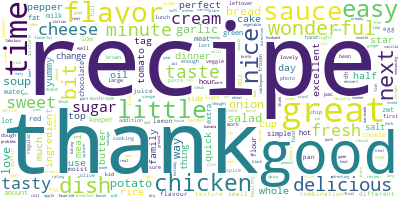

In [9]:
# Import the wordcloud library
from wordcloud import WordCloud
import itertools

# Join the different processed titles together
list_of_words = list(itertools.chain.from_iterable(data_lemmatized))
long_string = ','.join(word for word in list_of_words)
long_string

# # Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue', collocations = False,  random_state=1)

# # Generate a word cloud
wordcloud.generate(long_string)

# # Visualize the word cloud
wordcloud.to_image()

# Create Corpus

In [10]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Filter out tokens that appear in only 1 documents and appear in more than 90% of the documents
id2word.filter_extremes(no_below=2, no_above=0.9)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [11]:
# Create a dictionary representation of the documents. Each word gets an id
print('Sample word to id mappings:\n', list(id2word.items())[:50])
print()
print('Total Vocabulary Size:', len(id2word))

Sample word to id mappings:
 [(0, 'holiday'), (1, 'office'), (2, 'party'), (3, 'bit'), (4, 'dilute'), (5, 'easy'), (6, 'good'), (7, 'little'), (8, 'make'), (9, 'recipe'), (10, 'salad'), (11, 'thick'), (12, 'white'), (13, 'wine'), (14, 'casserole'), (15, 'nice'), (16, 'put'), (17, 'bland'), (18, 'blue'), (19, 'cheddar'), (20, 'cheese'), (21, 'cold'), (22, 'lunch'), (23, 'next'), (24, 'sandwich'), (25, 'sharp'), (26, 'time'), (27, 'cool'), (28, 'great'), (29, 'guest'), (30, 'pie'), (31, 'shell'), (32, 'town'), (33, 'whip'), (34, 'potato'), (35, 'thank'), (36, 'chicken'), (37, 'marinade'), (38, 'sauce'), (39, 'secret'), (40, 'beat'), (41, 'garlic'), (42, 'stuff'), (43, 'sure'), (44, 'blueberry'), (45, 'fine'), (46, 'froze'), (47, 'lemon'), (48, 'week'), (49, 'cooked')]

Total Vocabulary Size: 10249


# Building LDA Model

## Hyperparameter Tuning for LDA Model

In [18]:
# supporting function
def compute_evaluation_values(corpus, dictionary, k):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    log_perplexity = lda_model.log_perplexity(corpus)
    perplexity = 2**(-log_perplexity)
    
    return [coherence_model_lda.get_coherence(), perplexity]

In [23]:
# Iterate over possible number of topics.
topic_param = []
coherence_score = []
perplexity_score = []

for k in range(2, 20):
    print('topic number: ', k)
    ev = compute_evaluation_values(corpus=corpus, dictionary=id2word, k=k)
    coherence_score.append(ev[0])
    perplexity_score.append(ev[1])
    print('Coherence Score: ', ev[0])
    print('Perplexity Score: ', ev[1])
    print()
    
    topic_param.append(k)

topic number:  2
Coherence Score:  0.34301319105603567
Perplexity Score:  104.83017220795867

topic number:  3
Coherence Score:  0.3926351881446371
Perplexity Score:  106.02889295109792

topic number:  4
Coherence Score:  0.427237315182363
Perplexity Score:  107.38554124866201

topic number:  5
Coherence Score:  0.41012803424018396
Perplexity Score:  111.03562121782124

topic number:  6
Coherence Score:  0.4278471412522851
Perplexity Score:  113.36471498911017

topic number:  7
Coherence Score:  0.4146499081983972
Perplexity Score:  116.50879265205157

topic number:  8
Coherence Score:  0.401888916122187
Perplexity Score:  119.02570824969753

topic number:  9
Coherence Score:  0.4229822683838184
Perplexity Score:  124.98252523677456

topic number:  10
Coherence Score:  0.4414181131176294
Perplexity Score:  133.68189400510136

topic number:  11
Coherence Score:  0.44451026205110133
Perplexity Score:  149.48048927330825

topic number:  12
Coherence Score:  0.426909679822935
Perplexity Sc

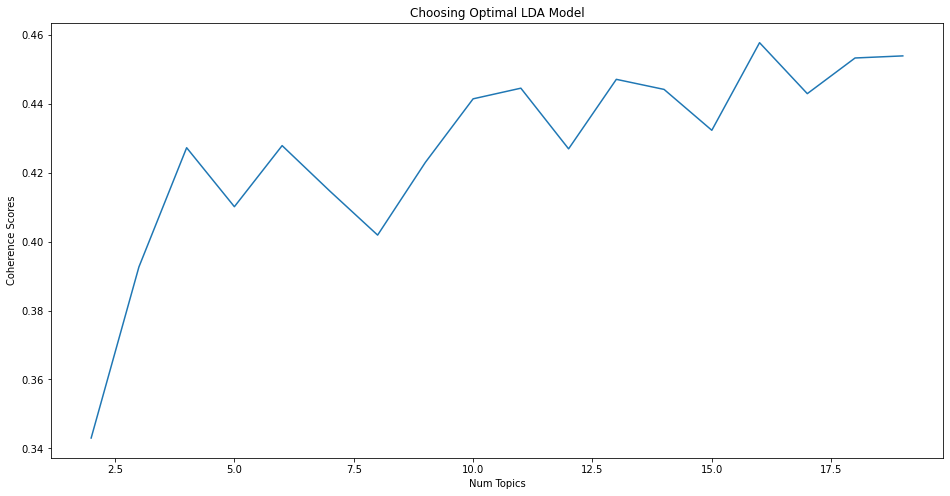

In [25]:
# Show graph
plt.figure(figsize=(16, 8))
plt.plot(topic_param, coherence_score)

plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Coherence Scores")
plt.show()

## Final LDA Model

In [26]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=16, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [27]:
# Print the Keyword in the 16 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.061*"star" + 0.040*"recipe" + 0.036*"minute" + 0.031*"pan" + 0.017*"top" '
  '+ 0.016*"small" + 0.016*"rating" + 0.014*"taste" + 0.013*"dh" + '
  '0.013*"large"'),
 (1,
  '0.084*"chicken" + 0.051*"recipe" + 0.029*"hour" + 0.028*"thank" + '
  '0.026*"sauce" + 0.022*"meat" + 0.019*"tender" + 0.019*"breast" + '
  '0.018*"pork" + 0.016*"great"'),
 (2,
  '0.068*"zwt" + 0.048*"thank" + 0.042*"flavor" + 0.033*"nice" + 0.032*"juice" '
  '+ 0.030*"lemon" + 0.024*"sweet" + 0.023*"great" + 0.022*"drink" + '
  '0.022*"summer"'),
 (3,
  '0.075*"fresh" + 0.045*"tomato" + 0.042*"bean" + 0.035*"recipe" + '
  '0.030*"thank" + 0.029*"green" + 0.028*"herb" + 0.025*"dish" + 0.024*"corn" '
  '+ 0.020*"spinach"'),
 (4,
  '0.092*"cheese" + 0.052*"fat" + 0.045*"soup" + 0.040*"lunch" + 0.039*"thank" '
  '+ 0.034*"low" + 0.030*"recipe" + 0.026*"great" + 0.025*"cream" + '
  '0.024*"free"'),
 (5,
  '0.144*"potato" + 0.045*"bacon" + 0.031*"pot" + 0.030*"personal" + '
  '0.027*"burger" + 0.027*"seed" + 0.

In [28]:
def Sort_Tuple(tup):  
    return(sorted(tup, key = lambda x: x[1], reverse = True))

In [29]:
doc_num, topic_num, prob = [], [], []
print(lda_model.get_document_topics(corpus))
for n in range(len(ori_df)):
    get_document_topics = lda_model.get_document_topics(corpus[n])
    doc_num.append(n)
    sorted_doc_topics = Sort_Tuple(get_document_topics)
    topic_num.append(sorted_doc_topics[0][0])
    prob.append(sorted_doc_topics[0][1])

In [30]:
ori_df['Doc'] = doc_num
ori_df['Topic'] = topic_num
ori_df['Probability'] = prob

In [31]:
df_final = ori_df[['recipe_id', 'category', 'name', 'date', 'review', 'rating', 'Topic', 'Probability']]
df_final

,recipe_id,category,name,date,review,rating,Topic,Probability
0,5315,beverages,icy holiday punch,2001-04-24,I brought this to an office holiday party and ...,4,15,0.515675
1,8661,salads,oliveau salad dressing,2001-08-05,Good recipe and easy to make. I found it a li...,4,6,0.372126
2,10859,vegetables,broccoli cauliflower and rice casserole,2001-08-15,This is a nice casserole. It is very easy to ...,2,4,0.765603
3,902,vegetables,microwaved garlic mushroom rolls,2001-08-16,Very easy to make for a lunch. I served it co...,3,4,0.637960
4,10722,desserts,cherry cream cheese pie,2001-09-04,I like easy and good. I bought the pie shell ...,5,15,0.430434
...,...,...,...,...,...,...,...,...
72252,349813,vegetables,healthier french fries and budget friendly,2010-09-08,This is a really nice basic fries recipe. I li...,4,6,0.246786
72253,76930,pasta,funky chicken with sesame noodles,2010-09-08,Fantastic! My boys devoured it! I used light s...,5,1,0.334716
72254,214193,desserts,no egg tomato soup cake,2010-09-08,"Oh wow, this is a really, really good cake rec...",5,8,0.678158
72255,177792,vegetables,chili potato dippers with cheddar jalapeno dip,2010-09-08,"Mmm, yummy!!!! The fries are so spicy and yumm...",5,11,0.308798


In [32]:
df_final.to_csv("topic_modelling.csv", index=False)

## Model Evaluation

In [35]:
# Compute Perplexity
log_perplexity = lda_model.log_perplexity(corpus)
perplexity = 2**(-log_perplexity)
print('Perplexity: ', perplexity)  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Perplexity:  258.42377854358426
Coherence Score:  0.45265047770808325


# Visualisation

In [36]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.184758  0.037588       1        1  10.375462
6      0.081612  0.033364       2        1  10.140674
1      0.071890  0.016185       3        1   8.058338
12     0.002333 -0.145184       4        1   6.945750
8      0.071424 -0.050589       5        1   6.747193
13    -0.020360 -0.003177       6        1   6.648600
2      0.084800  0.103228       7        1   6.515740
9      0.018609 -0.158839       8        1   6.155094
0     -0.013153 -0.226866       9        1   6.129119
4      0.058714  0.069515      10        1   5.552207
3     -0.014067  0.228054      11        1   5.232789
11    -0.111745  0.138471      12        1   4.894124
15     0.152460  0.042754      13        1   4.816783
10    -0.127498 -0.217645      14        1   4.500837
14    -0.387931  0.084773      15        1   4.063512
5     -0.051844  0.048367      16        1   3.223778, topic_info=         Term          Freq         Total Category  logprob  loglift
38      sauce  10591.000000  10591.000000  Default  30.0000  30.0000
2140      tag   7203.000000   7203.000000  Default  29.0000  29.0000
36    chicken   9149.000000   9149.000000  Default  28.0000  28.0000
34     potato   5567.000000   5567.000000  Default  27.0000  27.0000
20     cheese   6122.000000   6122.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
240    keeper    343.323431   2916.414827  Topic16  -4.7234   1.2952
6        good    426.102020  19518.304095  Topic16  -4.5074  -0.3898
9      recipe    478.613891  48496.476415  Topic16  -4.3911  -1.1837
28      great    381.417063  18970.175312  Topic16  -4.6182  -0.4721
76        way    322.426721   5332.343461  Topic16  -4.7862   0.6289

[948 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
2616     11  0.995853           abit
1690     14  0.994231  accompaniment
1822     15  0.961296        acidity
1251      3  0.994053     adjustment
835       8  0.998663      afternoon
...     ...       ...            ...
1813      7  0.995020            zip
772       2  0.415386       zucchini
772      10  0.166471       zucchini
772      15  0.416971       zucchini
7467      7  0.999900            zwt

[1916 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 7, 2, 13, 9, 14, 3, 10, 1, 5, 4, 12, 16, 11, 15, 6])

## Word Count of Topic Keywords

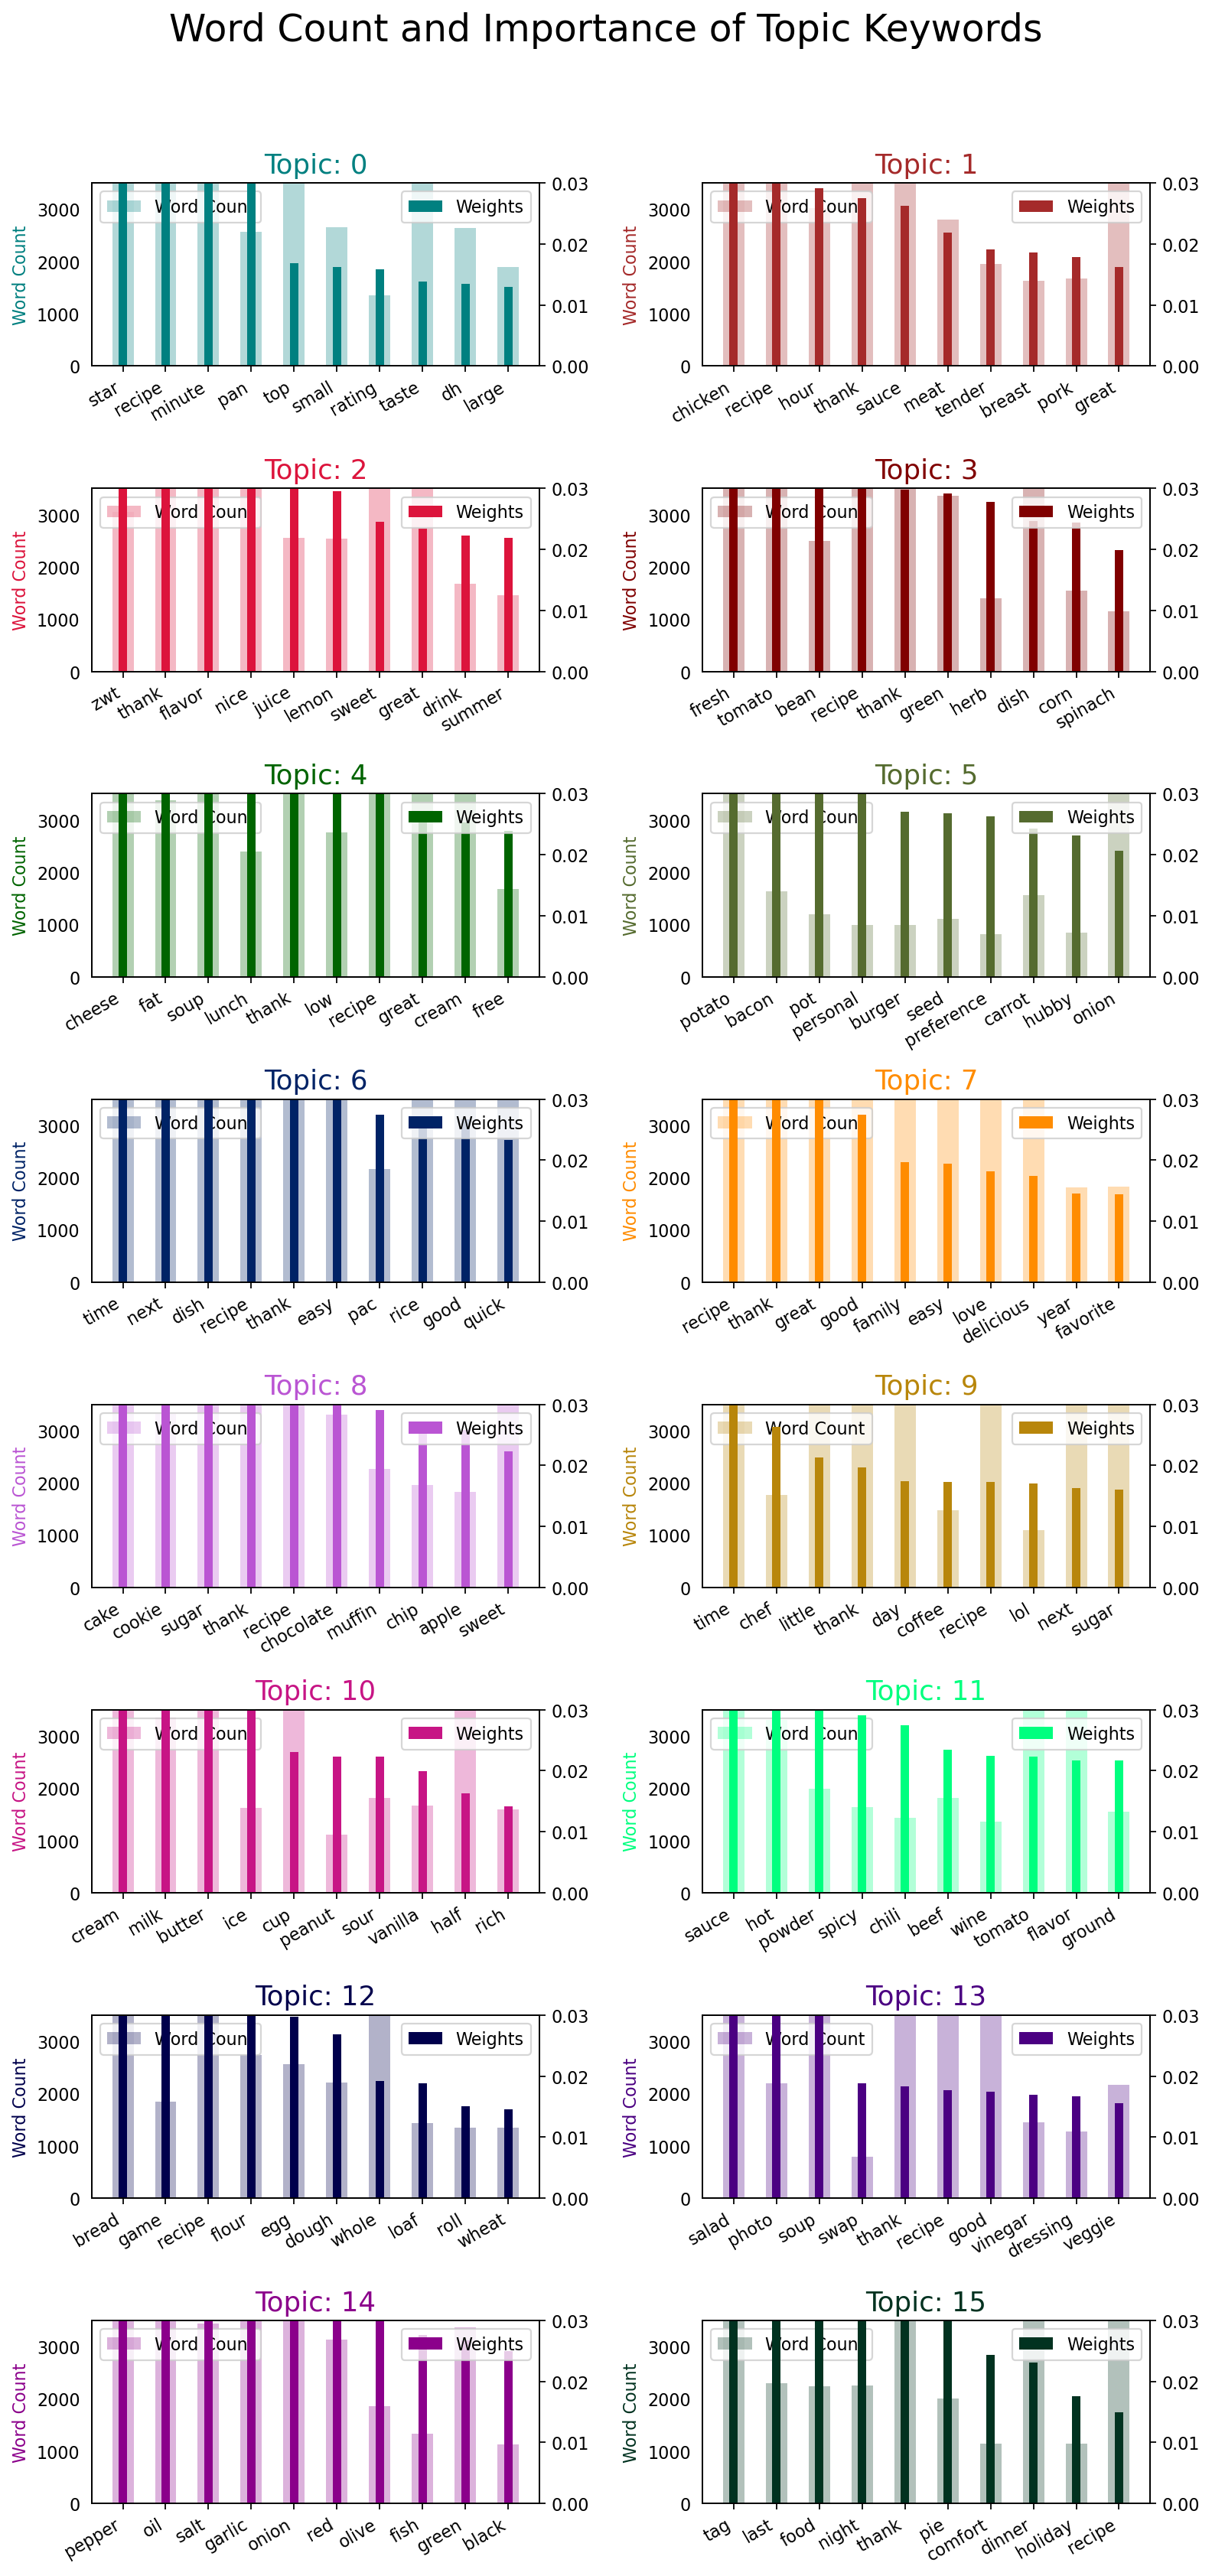

In [37]:
from collections import Counter
topics = lda_model.show_topics(num_topics=16, formatted=False)
data_flat = [w for w_list in data_lemmatized for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(8, 2, figsize=(10,20), dpi=160)
cols = ['#008080', '#A52A2A', '#DC143C', '#800000', '#006400', '#556b2f', '#002366', '#ff8c00', 
        '#ba55d3', '#b8860b', '#C71585', '#00ff7f', '#00004C', '#4B0082', '#8B008B', '#013220']

for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')


fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()